In [1]:
import GPy, numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import HTML

In [2]:
from animate_gp import animate_kernel, plot_data, create_empty_ax, fill_grad

In [3]:
from GPy.core.parameterization.param import Param
from paramz.transformations import Logexp

class LnNormBasisFunc(GPy.kern.BasisFuncKernel):
    """
    LogNormal distribution kernel bases.
    
    This kernel adds log normal distributed basis functions as kernel.
    
    You can either define the starting positions for the basis functions, or for each
    extra dimension in `extra_dims` we create one LogNormal base per non-zero entry.
    The base will start at the active_dim corresponding to that entry.
    
    We learn a shape and elongation parameter per base.
    """
    def __init__(
        self, input_dim, 
        shapes=1., elongations=1., variance=1., 
        starts=None, extra_dims=None, 
        active_dims=None, ARD=False, name='ln_norm'
    ):
        assert starts is None or extra_dims is None, "Can either take starts from X, or predefine at init"
        
        self.extra_dims = np.asarray(extra_dims) if extra_dims is not None else None
        if active_dims is None:
            active_dims = np.arange(input_dim)
        else:
            active_dims = np.asarray(active_dims)
        
        if self.extra_dims is None:
            self._starts = starts
            self.shapes = Param('shapes', shapes*np.ones(starts.size), Logexp())
            self.elongations = Param('elongations', elongations*np.ones(starts.size), Logexp())
            self.time_dims = slice(None)
            _warn_input_dim = True
        else:
            self.shapes = Param('shapes', shapes*np.ones(self.extra_dims.size), Logexp())
            self.elongations = Param('elongations', elongations*np.ones(self.extra_dims.size), Logexp())
            self.time_dims = active_dims.copy()
            active_dims = np.r_[active_dims, self.extra_dims]
            input_dim = active_dims.size
            _warn_input_dim = False
        
        self.sqrt_2_pi = np.sqrt(2*np.pi)
        super(LnNormBasisFunc, self).__init__(input_dim, variance, active_dims, ARD, name, _warn_input_dim=_warn_input_dim)
        self.link_parameters(self.shapes, self.elongations)
    
    def _get_x_starts(self, X):
        if self.extra_dims is None:
            return self._starts[None, :], np.eye(self.shapes.size), np.arange(self.shapes.size)
        else:
            start_elems = X[:, self.extra_dims].nonzero()
            choice = start_elems[1]
            starts = X[start_elems[0], self.time_dims]
            start_amplitudes = np.zeros((starts.size, self.extra_dims.size))
            start_amplitudes[np.arange(starts.size), choice] = X[:, self.extra_dims][start_elems]
            
            return starts[None, :]+1e-6, start_amplitudes, start_elems[1]
    
    def _inner_phi(self, x, choice, mu, sigma):
        with np.errstate(divide='ignore', invalid='ignore'):
            phi = np.exp(-((np.log(mu * x))**2/(2*sigma))) / (np.sqrt(2 * np.pi * sigma) * mu * x)
            phi[np.isnan(phi)] = 0.0
        return phi
    
    def _phi(self, X):
        _X, amps, sigma, mu, choice = self._get_transformed_X(X)
        return self._inner_phi(_X, choice, mu, sigma).dot(amps)
    
    def _get_transformed_X(self, X):
        starts, amps, choice = self._get_x_starts(X)
        sigma = np.choose(choice, self.shapes)[None, :]
        mu = np.choose(choice, self.elongations)[None, :]
        _X = X[:, self.time_dims] - starts
        return _X, amps, sigma, mu, choice
    
    def _grads_for_X(self, X):
        X1, amps, sigma, mu, choice = self._get_transformed_X(X)
        phi1 = self._inner_phi(X1, choice, mu, sigma)
        
        with np.errstate(divide='ignore', invalid='ignore'):
            ln_mu_x = np.log(mu * X1)
            ln_mu_x[np.isnan(ln_mu_x)] = 0.
            
            d_phi1_ds = np.einsum(
                "ij,ij,ij,jq->iq",
                phi1,
                (ln_mu_x**2 - sigma),
                1./ (2 * sigma**2),
                amps)
            d_phi1_ds[np.isnan(d_phi1_ds)] = 0.
            
            d_phi1_dmu = np.einsum(
                "ij,ij,ij,jq->iq",
                phi1,
                (sigma + ln_mu_x),
                1./ (sigma * mu),
                -amps)
            #import ipdb; ipdb.set_trace()
            d_phi1_dmu[np.isnan(d_phi1_dmu)] = 0.
        return phi1.dot(amps), d_phi1_ds, d_phi1_dmu
    
    def update_gradients_full(self, dL_dK, X, X2=None):
        super(LnNormBasisFunc, self).update_gradients_full(dL_dK, X, X2)
        
        phi1, d_phi1_ds, d_phi1_dmu = self._grads_for_X(X)
        
        phi2 = dphi2_dl = None
        
        if not(X2 is None or X is X2):
            phi2, d_phi2_ds, d_phi2_dmu = self._grads_for_X(X2)
            
        self.shapes.gradient[:] = self.d_K_d_theta_through_K(phi1, dL_dK, d_phi1_ds, phi2, dphi2_dl, ARD=True)
        self.elongations.gradient[:] = self.d_K_d_theta_through_K(phi1, dL_dK, d_phi1_dmu, phi2, dphi2_dl, ARD=True)
    
    

In [4]:
from GPy.models import GradientChecker
k_act = LnNormBasisFunc(1, extra_dims=[1,2], elongations=1., shapes=1., ARD=False)

def f(mu, sigma):
    k_act.shapes[:] = sigma
    k_act.elongations[:] = mu
    phi1, d_phi1_ds, d_phi1_dmu = k_act._grads_for_X(X)
    return phi1

def df(mu, sigma):
    k_act.shapes[:] = sigma
    k_act.elongations[:] = mu
    phi1, d_phi1_ds, d_phi1_dmu = k_act._grads_for_X(X)
    return d_phi1_dmu, d_phi1_ds

def df_(mu, sigma):
    d_phi1_dmu, d_phi1_ds = df(mu, sigma)
    return d_phi1_dmu.sum(0), d_phi1_ds.sum(0)

In [6]:
# plt.plot(X[:,[0]], f(k_act.elongations, k_act.shapes))

# dfmu, dfs = df(k_act.elongations, k_act.shapes)
# plt.plot(X[:,[0]], dfmu)
# #plt.plot(X[:,[0]], dfs)

In [36]:
np.random.seed(1000)

k_f = GPy.kern.Matern32(1, variance=1.)
k_act = LnNormBasisFunc(1, extra_dims=[1,2], elongations=1., shapes=1., ARD=False)
k_act.randomize()

In [37]:
N = 500
__X = np.random.uniform(-5, 5, N)[:,None]
__X.sort(0)
X = np.c_[
    __X,
    np.random.binomial(1, 0.01, size=N)[:, None] * np.random.uniform(10, 50, N)[:,None],
    np.random.binomial(1, 0.001, size=N)[:, None] * np.random.uniform(30, 200, N)[:,None]
]

#X[:, 1:] = 0
#X[0, 1:] = .5
#X[int(N/2), 1] = 2.
#X[int(N/2)+150, 2] = 1

K_f = k_f.K(X)
f_se = np.random.multivariate_normal(np.zeros(X.shape[0]), K_f, (1)).T

K_act = k_act.K(X)
f_act = np.random.multivariate_normal(np.zeros(X.shape[0]), K_act, (1)).T

Y = f_se + f_act + np.random.normal(0, .2, f_se.shape)

In [41]:
np.random.seed(1234)

choice = np.random.choice(X.shape[0], N, replace=False)
choice.sort(0)

_X = X[choice]
_Y = Y[choice]

m = GPy.models.GPRegression(_X, _Y, kernel=(k_f + k_act).copy(), normalizer=True)
m.likelihood.variance = .01
#m.optimize()

In [42]:
m.checkgrad(1)

                     Name                      |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-------------------------------------------------------------------------------------------------------------------------------
 GP_regression.sum.Mat32.variance              |   1.000006    |   0.000100    |   18.173899   |   18.174000   |     7e-08     
 GP_regression.sum.Mat32.lengthscale           |   1.000000    |   0.000005    |  -44.547199   |  -44.547194   |     2e-07     
 GP_regression.sum.ln_norm.variance            |   0.999683    |   0.000264    |   0.834327    |   0.834063    |     3e-09     
 GP_regression.sum.ln_norm.shapes[[0]]         |   0.999964    |   0.000056    |   -1.557187   |   -1.557131   |     6e-09     
 GP_regression.sum.ln_norm.shapes[[1]]         |   1.000017    |   0.000033    |   1.996821    |   1.996854    |     7e-09     
 GP_regression.sum.ln_norm.elongations[[0]]    |   1.000678    |   0.000248    |   -0.365869   |   -0.36

True

{'dataplot': [<matplotlib.collections.PathCollection at 0x1a21f64710>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a21f64630>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a21f64b70>]}

 /Users/maxz/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


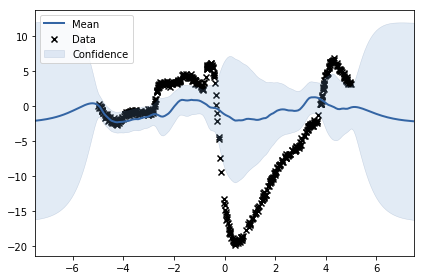

In [43]:
m.plot(visible_dims=[0])

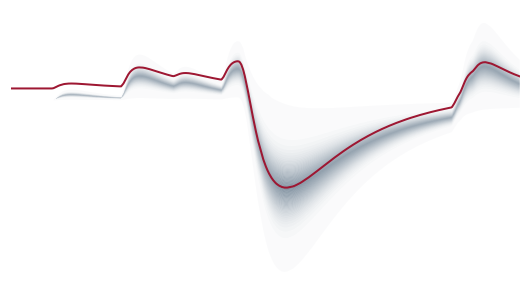

In [46]:
fig, ax = create_empty_ax()
ax.set_xlim(X[:,0].min(), X[:,0].max())
fig.tight_layout()

_mu, _K = m.predict_noiseless(X, full_cov=True, kern=m.kern.ln_norm.copy())
fill_grad(ax, X, _mu, _K)
ax.plot(X[:,[0]], f_act, color='#9e1732', lw=2)

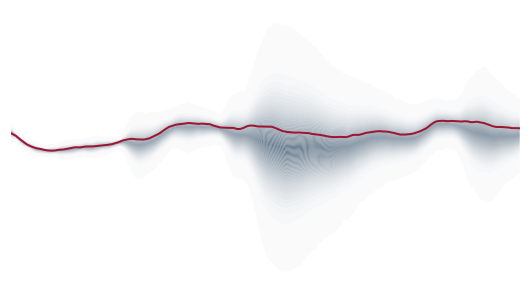

In [47]:
fig, ax = create_empty_ax()
ax.set_xlim(X[:,0].min(), X[:,0].max())
fig.tight_layout()

_mu, _K = m.predict_noiseless(X, full_cov=True, kern=m.kern.Mat32.copy())
fill_grad(ax, X, _mu, _K)

ax.plot(X[:, 0], f_se, color='#9e1732', lw=2)

In [48]:
_mu, _K = m.predict_noiseless(X, full_cov=True, kern=m.kern.ln_norm.copy())

fig, ax = create_empty_ax()
ax.set_xlim(X[:,0].min(), X[:,0].max())
fig.tight_layout()
fill_grad(ax, X, _mu, _K)
#plot_data(ax, _X, _Y)
ax.plot(X[:,0], f_act, color='#9e1732', lw=2)
anim = animate_kernel(fig, ax, X, _mu, _K, 'activation_gp_ln_norm.mp4', frames=100)
plt.close(fig)
jshtml = anim.to_jshtml()
HTML(jshtml)

In [49]:
_mu, _K = m.predict_noiseless(X, full_cov=True, kern=m.kern.Mat32.copy())

fig, ax = create_empty_ax()
ax.set_xlim(X[:,0].min(), X[:,0].max())
fig.tight_layout()
fill_grad(ax, X, _mu, _K)
#plot_data(ax, _X, _Y)
ax.plot(X[:, [0]], f_se, color='#9e1732', lw=2)
anim = animate_kernel(fig, ax, X, _mu, _K, 'activation_gp_mat.mp4', frames=100)
plt.close(fig)
jshtml = anim.to_jshtml()
HTML(jshtml)

In [50]:
_mu, _K = m.predict_noiseless(X, full_cov=True)

fig, ax = create_empty_ax()
ax.set_xlim(X[:,0].min(), X[:,0].max())
fig.tight_layout()
fill_grad(ax, X, _mu, _K)
plot_data(ax, _X[:,[0]], _Y)
ax.plot(X[:, [0]], f_se+f_act, color='#9e1732', lw=2)
anim = animate_kernel(fig, ax, X, _mu, _K, 'activation_gp_all.mp4', frames=100)
plt.close(fig)
jshtml = anim.to_jshtml()
HTML(jshtml)

In [51]:
m.optimize(messages=1)

In [ ]:
_mu, _K = m.predict_noiseless(X, full_cov=True, kern=m.kern.ln_norm.copy())

fig, ax = create_empty_ax()
ax.set_xlim(X[:,0].min(), X[:,0].max())
fig.tight_layout()
fill_grad(ax, X, _mu, _K)
#plot_data(ax, _X, _Y)
ax.plot(X[:,0], f_act, color='#9e1732', lw=2)
anim = animate_kernel(fig, ax, X, _mu, _K, 'activation_gp_ln_norm.mp4', frames=100)
plt.close(fig)
jshtml = anim.to_jshtml()
HTML(jshtml)